https://www.tensorflow.org/tutorials/images/segmentation

In [1]:
from IPython.display import clear_output

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

c:\Users\luisc\miniconda3\envs\image_segmenter\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 2/2 [01:30<00:00, 45.08s/ url]

Dl Completed...: 100%|██████████| 2/2 [01:47<00:00, 53.51s/ url]


Dataset oxford_iiit_pet downloaded and prepared to ~\tensorflow_datasets\oxford_iiit_pet\3.2.0. Subsequent calls will reuse this data.


In [4]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [5]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = tf.keras.layers.RandomFlip(mode='horizontal', seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode='horizontal', seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [9]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()

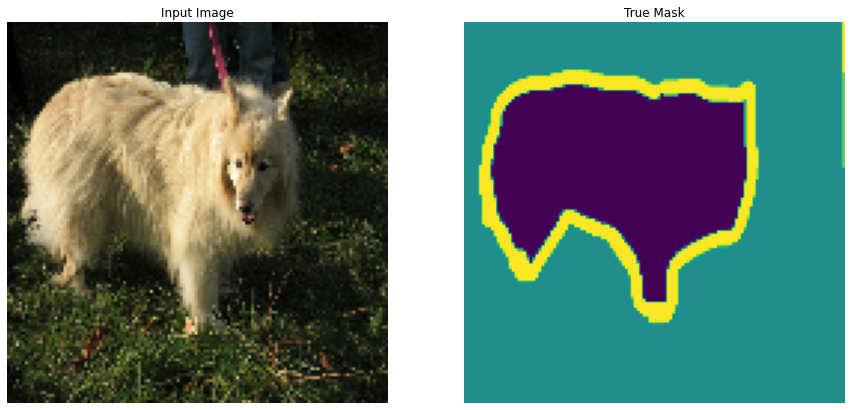

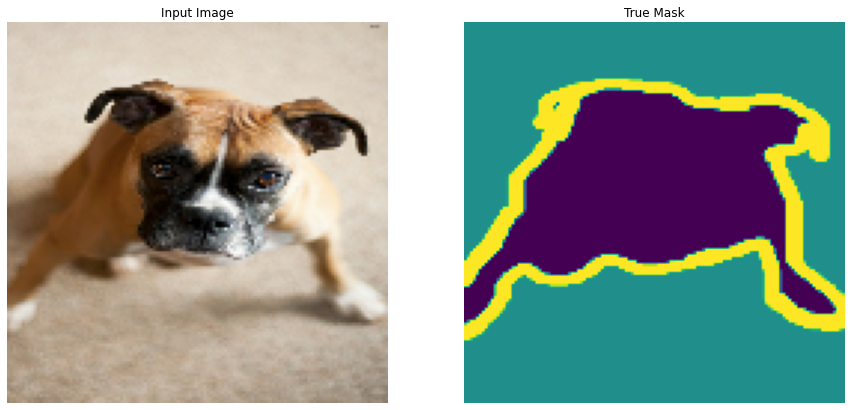

In [11]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [12]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=[128, 128, 3],
    include_top=False
)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu', # 64x64
    'block_3_expand_relu', # 32x32
    'block_6_expand_relu', # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project', # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model_outputs
)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [13]:
up_stack = [
    pix2pix.upsample(512, 3), # 4x4 -> 8x8
    pix2pix.upsample(256, 3), # 8x8 -> 16x16
    pix2pix.upsample(128, 3), # 16x16 -> 32x32
    pix2pix.upsample(64, 3), # 32x32 -> 64x64
]

In [14]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels,
        kernel_size=3,
        strides=2,
        padding='same'
    ) # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [17]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [18]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([
            sample_image,
            sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))
        ])

1/1 [==============================] - 9s 9s/step


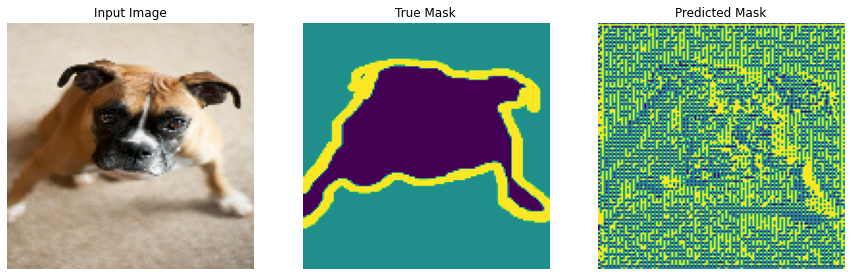

In [19]:
show_predictions()

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()

        print(f'Sample prediction after epoch: {epoch + 1}')

1/1 [==============================] - 0s 44ms/step


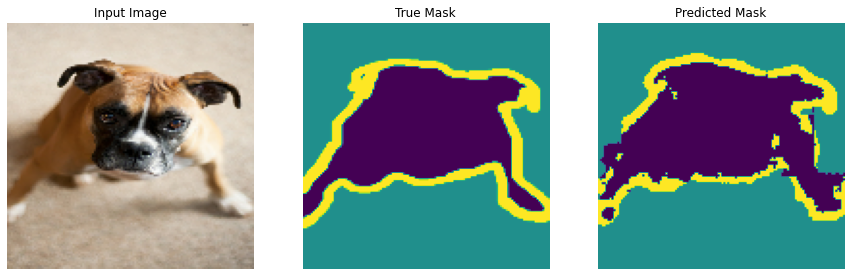

Sample prediction after epoch: 20
57/57 [==============================] - 11s 191ms/step - loss: 0.1847 - accuracy: 0.9184 - val_loss: 0.2704 - val_accuracy: 0.8963


In [21]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    callbacks=[DisplayCallback()]
)

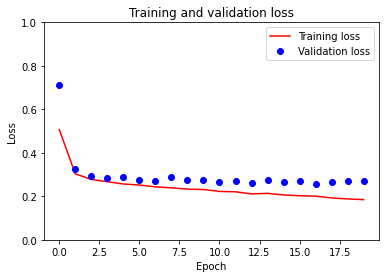

In [22]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()

plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend()

plt.show()

2/2 [==============================] - 0s 282ms/step


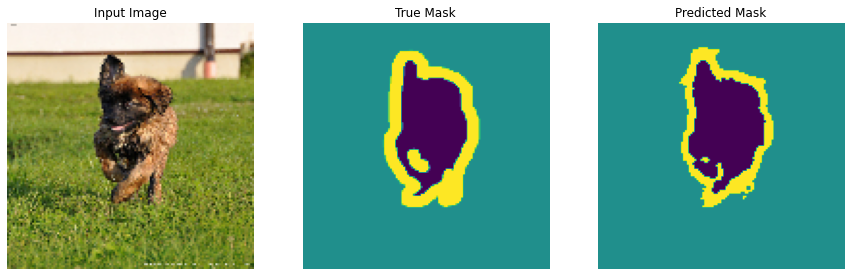

2/2 [==============================] - 0s 35ms/step


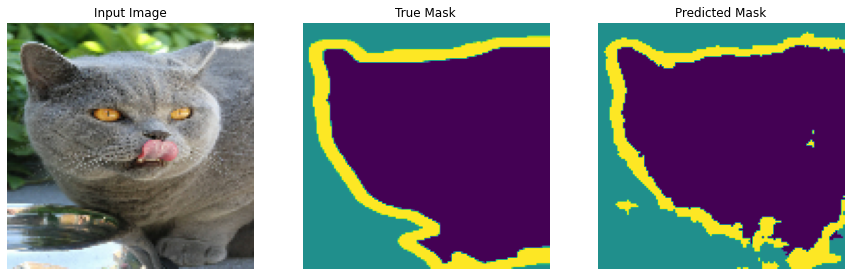

2/2 [==============================] - 0s 24ms/step


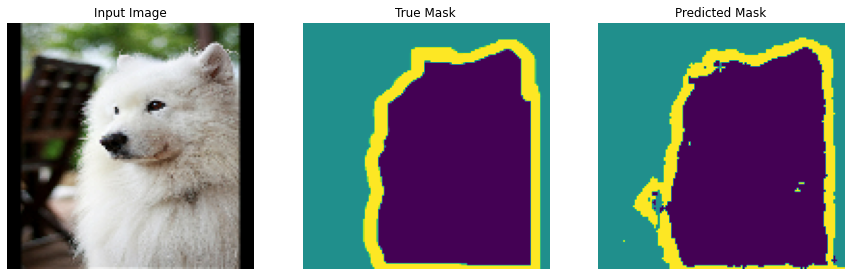

In [23]:
show_predictions(test_batches, 3)

In [24]:
try:
    model_history = model.fit(
        train_batches,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        class_weight = {0: 2.0, 1: 2.0, 2: 1.0}
    )

    assert False

except Exception as e:
    print(f'Expected {type(e).__name__}: {e}')

Expected ValueError: `class_weight` not supported for 3+ dimensional targets.


In [25]:
def add_sample_weights(image, label):
    # The weights for each class, with the constraint that:
        # sum(class_weights) == 1.0
    class_weights = tf.constant([2.0, 2.0, 1.0])
    class_weights = class_weights / tf.reduce_sum(class_weights)

    # Create an image of 'sample_weights' by using the label at each pixel as an index into the 'class weights'
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

In [26]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [27]:
weighted_model = unet_model(OUTPUT_CLASSES)

weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [28]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10
)

10/10 [==============================] - 4s 143ms/step - loss: 0.3104 - accuracy: 0.6144
